In [1]:
import warnings
warnings.filterwarnings("ignore")

from config import get_config
from train import train_model, grid_search

import torch
import inference_helpers

import json

In [2]:
## randomized search
num_models1 = 1
num_models2 = 8
best_model_params = []
for k in range(num_models1, num_models2+1):
    print(f"MODEL CROSS VALIDATING - #{k}")
    print(20*"--")
    config = get_config()

    ## hyperparameter tuning
    param_grid = {
            'max_depth': [2, 3, 4, 6, 8],
            'reg_alpha': [0.2, 0.5, 1, 5],
            'reg_lambda': [0.5, 2, 5, 8],
            'subsamaple': [0.5, 0.75, 1],
            'learning_rate': [0.5, 0.1, 0.05]
        }

    # param_grid = {
    #         'max_depth': [2, 3, 4, 6, 8, 12],
    #         'reg_alpha': [0, 0.2, 0.5, 1, 5],
    #         'reg_lambda': [0.5, 2, 5, 8],
    #         'subsamaple': [0.5, 0.75, 1],
    #         'learning_rate': [0.5, 0.1, 0.05]
    #     }

    config["tgt_step"] = k-1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    search_res = grid_search(config, device, lr_cv = None, n_cv = 150, param_grid = param_grid, n_iter = 720)
    # n_cv = 150, n_iter = 720
    
    best_model_params.append(search_res.best_params_)
    print("Best params:", str(search_res.best_params_))
    print(20*"--")

with open(f"{config['run']}_params.json", "w") as outfile: 
    json.dump({"param_grid": param_grid, "best_params": best_model_params}, outfile)

MODEL CROSS VALIDATING - #1
----------------------------------------
Fitting 4 folds for each of 720 candidates, totalling 2880 fits
[CV 1/4; 1/720] START learning_rate=0.5, max_depth=2, reg_alpha=0.2, reg_lambda=0.5, subsamaple=0.5
[CV 1/4; 1/720] END learning_rate=0.5, max_depth=2, reg_alpha=0.2, reg_lambda=0.5, subsamaple=0.5;, score=-19011.354 total time=   0.6s
[CV 2/4; 1/720] START learning_rate=0.5, max_depth=2, reg_alpha=0.2, reg_lambda=0.5, subsamaple=0.5
[CV 2/4; 1/720] END learning_rate=0.5, max_depth=2, reg_alpha=0.2, reg_lambda=0.5, subsamaple=0.5;, score=-18539.998 total time=   0.6s
[CV 3/4; 1/720] START learning_rate=0.5, max_depth=2, reg_alpha=0.2, reg_lambda=0.5, subsamaple=0.5
[CV 3/4; 1/720] END learning_rate=0.5, max_depth=2, reg_alpha=0.2, reg_lambda=0.5, subsamaple=0.5;, score=-14069.565 total time=   0.8s
[CV 4/4; 1/720] START learning_rate=0.5, max_depth=2, reg_alpha=0.2, reg_lambda=0.5, subsamaple=0.5
[CV 4/4; 1/720] END learning_rate=0.5, max_depth=2, reg_alp

In [8]:
import numpy as np

x_to_pred = np.random.rand(32*len(config['exo_vars']+config['target']))

In [3]:
best_model_params

[{'subsamaple': 0.5,
  'reg_lambda': 8,
  'reg_alpha': 1,
  'max_depth': 4,
  'learning_rate': 0.1},
 {'subsamaple': 0.5,
  'reg_lambda': 5,
  'reg_alpha': 5,
  'max_depth': 6,
  'learning_rate': 0.05},
 {'subsamaple': 0.5,
  'reg_lambda': 8,
  'reg_alpha': 0.2,
  'max_depth': 4,
  'learning_rate': 0.05},
 {'subsamaple': 0.5,
  'reg_lambda': 8,
  'reg_alpha': 1,
  'max_depth': 4,
  'learning_rate': 0.05},
 {'subsamaple': 0.5,
  'reg_lambda': 8,
  'reg_alpha': 1,
  'max_depth': 4,
  'learning_rate': 0.05},
 {'subsamaple': 0.5,
  'reg_lambda': 8,
  'reg_alpha': 1,
  'max_depth': 6,
  'learning_rate': 0.05},
 {'subsamaple': 0.5,
  'reg_lambda': 8,
  'reg_alpha': 5,
  'max_depth': 2,
  'learning_rate': 0.05},
 {'subsamaple': 0.5,
  'reg_lambda': 8,
  'reg_alpha': 5,
  'max_depth': 2,
  'learning_rate': 0.05}]

In [21]:
## Multiple model training
best_score = []
cfg = get_config()
num_models0 = 1
num_models1 = 8

for k in range(num_models0, num_models1+1):
    print(f"MODEL TRAINING - #{k}")
    print(20*"-")
    cfg = get_config()

    cfg["tgt_step"] = k-1
    cfg['run'] += f"_{k}"
    cfg['model_folder'] += cfg['run']
    cfg['experiment_name'] = f"runs{cfg['run']}/tmodel"

    for param_name in param_grid.keys():
        cfg[param_name] = best_model_params[k-1][param_name]

    model = train_model(cfg)
    best_score.append(model.best_score)

    # save config to JSON
    with open(f"{cfg['run']}.json", "w") as outfile: 
        json.dump(cfg, outfile)
    print(20*"-")

MODEL TRAINING - #1
--------------------
Using device: cuda
[0]	validation_0-mae:130.09092	validation_0-rmse:176.47221	validation_1-mae:122.70806	validation_1-rmse:169.88346
[1]	validation_0-mae:127.17141	validation_0-rmse:172.34258	validation_1-mae:119.91891	validation_1-rmse:165.84754
[2]	validation_0-mae:124.51632	validation_0-rmse:168.57906	validation_1-mae:117.41549	validation_1-rmse:162.20419
[3]	validation_0-mae:122.13715	validation_0-rmse:165.14322	validation_1-mae:115.16016	validation_1-rmse:158.87662
[4]	validation_0-mae:119.90062	validation_0-rmse:161.99001	validation_1-mae:113.03308	validation_1-rmse:155.80936
[5]	validation_0-mae:117.92064	validation_0-rmse:159.12746	validation_1-mae:111.15244	validation_1-rmse:152.98090
[6]	validation_0-mae:116.08236	validation_0-rmse:156.49191	validation_1-mae:109.42620	validation_1-rmse:150.39412
[7]	validation_0-mae:114.41899	validation_0-rmse:154.11958	validation_1-mae:107.82364	validation_1-rmse:148.01973
[8]	validation_0-mae:112.909

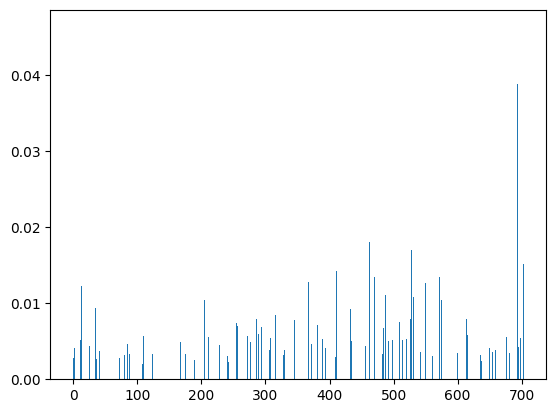

In [22]:
import matplotlib.pyplot as plt

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [23]:
#print(model.get_params())
best_score

[116.90936154296989,
 140.09710282548113,
 148.5220920230499,
 153.0192788340644,
 160.37869417185598,
 164.34987269307337,
 166.64099152334418,
 167.10044863057553]

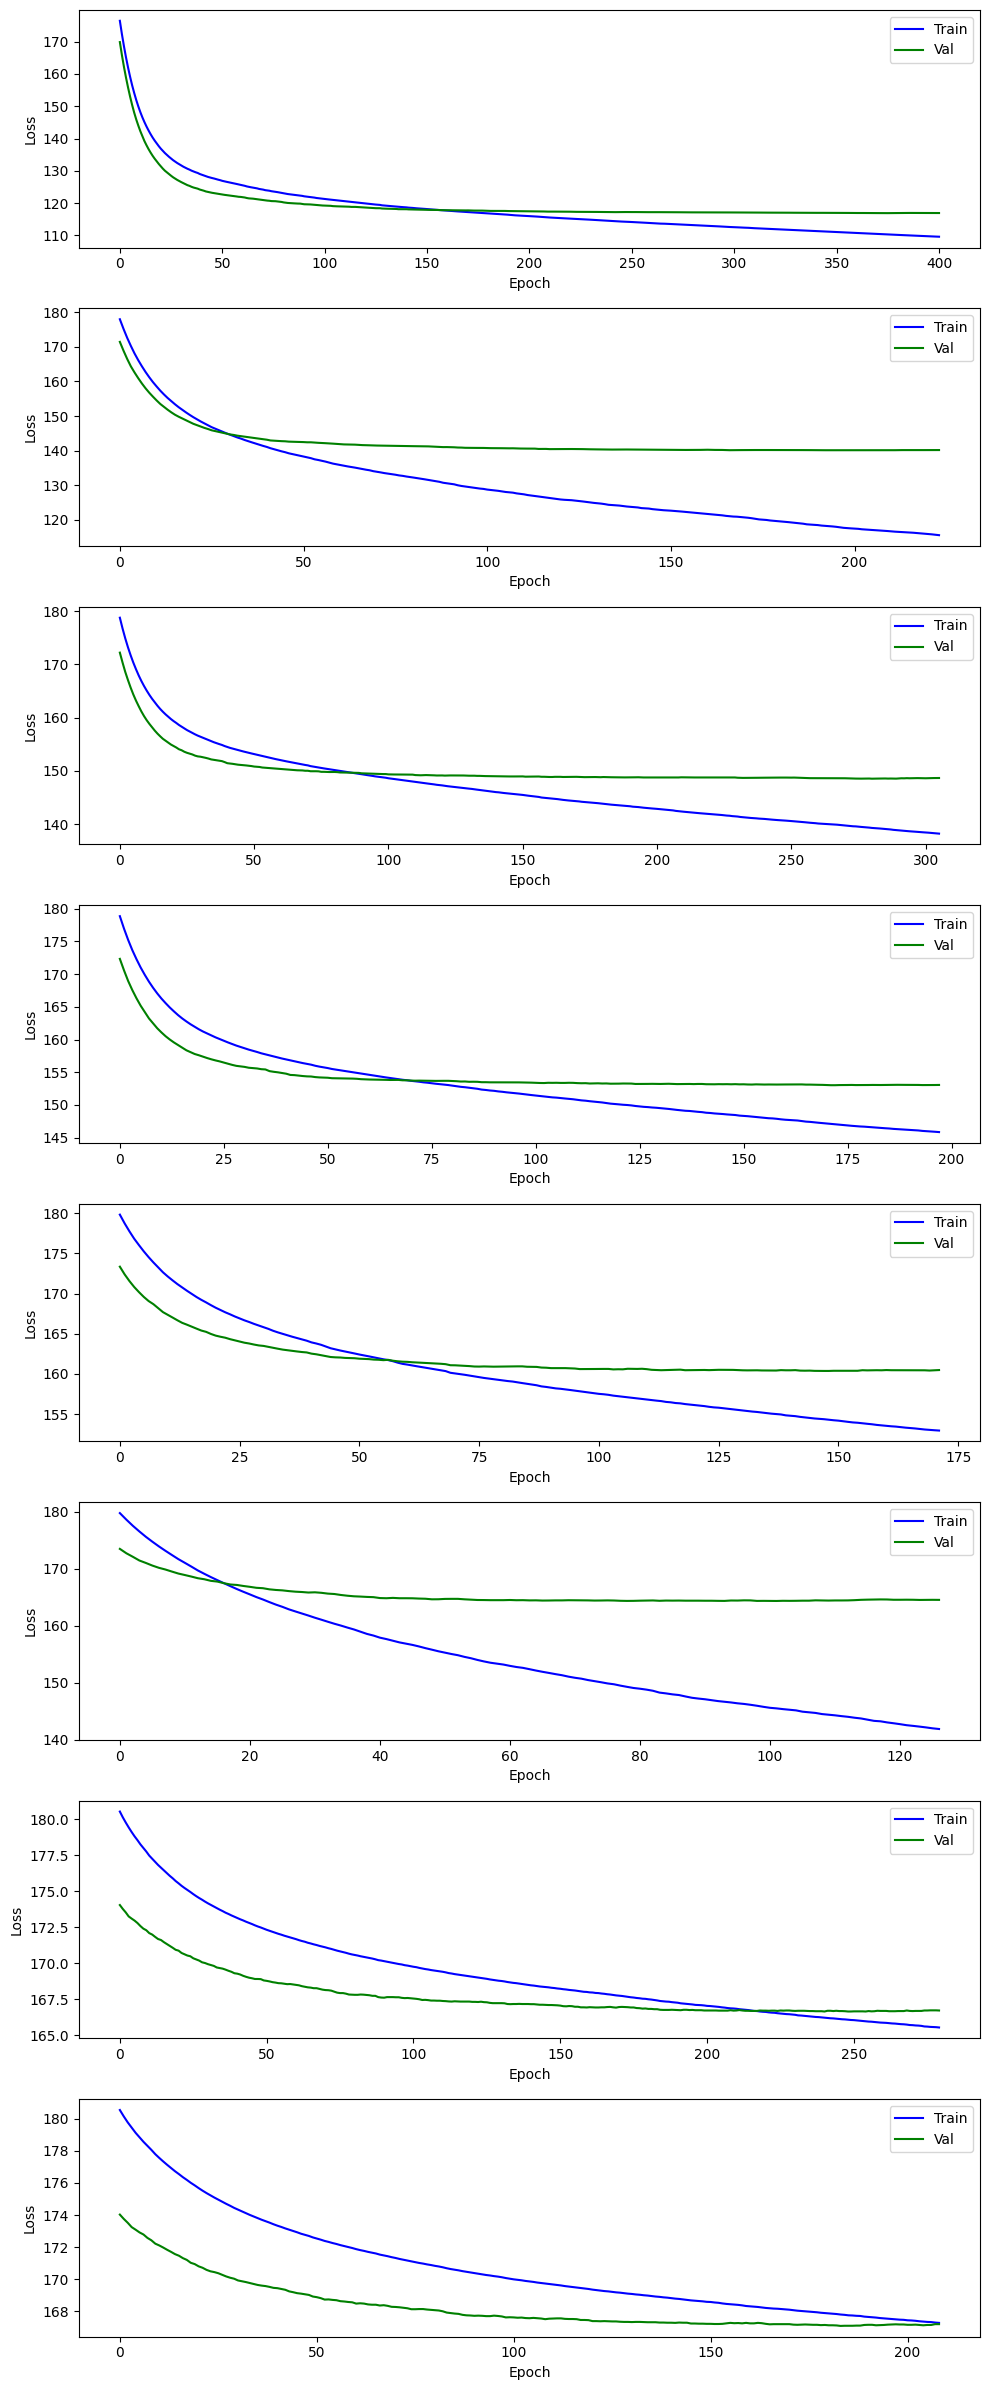

In [24]:
inference_helpers.arrange_figures_in_rows(n_rows=num_models1, prefix="final_nfl_")

In [ ]:
# pozorovani
# -- xgboost vyuziva vsechny stromy k predikci, dohormady davaji nejlepsi
# prediktor az do k-te vrstvy
# -- posledni z eval_metrics se pouziva k early_stopping, takze je treba je usporadat
# -- validacni sada bude potreba k treninku, tudiz musim sehnat i testovaci sadu
# ? mozna bych mohl dostahovat aktualni data